In [1]:
import pandas as pd # 데이터 분석
import numpy as np # 행렬 연산
import random # 시드 제어
from pandas import Series, DataFrame
import sys
import time
import re

import datetime
from workalendar.asia import SouthKorea # 한국의 공휴일

import lightgbm as lgb
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor # 모델링

# 시드
import os
seed = 12345
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
random.seed(seed)

In [2]:
# load dataset
final_ans = pd.read_csv('section_2week.csv', sep=',')
final_ans_test = pd.read_csv('section_2week_test.csv', sep=',')

final = pd.concat([final_ans, final_ans_test])
final = final.reset_index()
del final['index']

final = final.sort_values(by=['date'], axis=0)

# date의 데이터 형식이 'yyyy-mm-dd'인 string이어서 lightgbm 내부에서 float으로 데이터를 변형시키지
# 못하여 데이터의 형식을 'yyyymmdd'로 변환
date_lst = []
for value in final['date'].values:
    val = re.sub(r"[-]","",value)
    date_lst.append(val)
final['date'] = date_lst

X = final[final_ans.columns.difference(['power'])]
Y = final['power']

X['date'] = X['date'].astype(float)

col = ['date','day','dayofweek','holiday','month','power_d',
       'power_d1','power_d10','power_d11','power_d12','power_d13','power_d14',
       'power_d2','power_d3','power_d4','power_d5','power_d6','power_d7',
       'power_d8','power_d9','week','weekend','year']
X_not = X[col]
X_not['date'] = X_not['date'].astype(float)

x_train, x_valtest, y_train, y_valtest = train_test_split(X_not, Y, test_size = 0.2, shuffle=False, random_state=seed)
x_val, x_test, y_val, y_test = train_test_split(x_valtest, y_valtest, test_size = 0.5, shuffle=False, random_state=seed)
print(x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape)

(83271, 23) (83271,) (10409, 23) (10409,) (10409, 23) (10409,)


c:\users\ilifo-028\anaconda3\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
c:\users\ilifo-028\anaconda3\lib\site-packages\ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [3]:
tree = DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=5,
                             max_features=len(col),
                             max_leaf_nodes=None, min_impurity_decrease=0.0, 
                             min_impurity_split=None, min_samples_leaf=1,
                             min_samples_split=2, min_weight_fraction_leaf=0.0,
                             presort='deprecated', random_state=seed, splitter='best')

In [5]:
def smape(array_1, array_2):
    score = 100*np.mean(2*abs(array_1 - array_2)/(abs(array_1)+abs(array_2)))
    return score

In [6]:
tree_fit = tree.fit(x_train, y_train)
predictions = tree_fit.predict(x_test)
validations = tree_fit.predict(x_val)
test_score = smape(predictions, y_test)
val_score = smape(validations, y_val)
print(val_score)
print(test_score)

13.867524676035725
13.976457645694317


In [7]:
from sklearn.tree import export_graphviz
export_graphviz(tree, out_file='tree.dot', feature_names=col, impurity=False, filled=True)

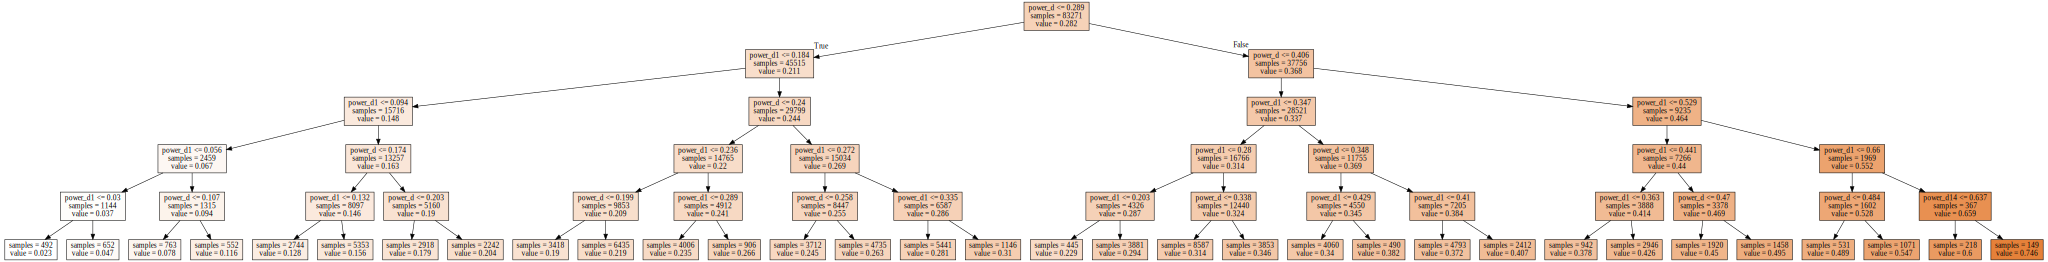

In [8]:
import graphviz

with open('tree.dot','r',encoding='UTF-8') as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))

In [ ]:
'''
https://www2.graphviz.org/Packages/stable/windows/10/msbuild/Release/Win32/
1. 2.38-win32.msi 설치
2. 환경 변수에 설치된 경로 추가 C:\Program Files (x86)\Graphviz2.38\bin
3. 코드 실행
'''